# Astrometry from CCD Images

For this lab we will attempt to measure stars relative to the celestial coordinate system using CCD images of a part of the sky. The data is taken using the Dunlap Institute telescope (DIT) located on Mt. Joy in New Mexico. We will use images of the NGC 7331 galaxy for this lab and compare it with the USNO (US Naval Observatory) B-1.0 star catalog as our reference. In doing so, we are able to solve for the plate constants of the telescope and correct our image to that of the USNO catalog. 

## Reading FITS

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import find_peaks

from matplotlib.colors import LogNorm

In [4]:
ngc = fits.getdata('NGC7331-S001-R001-C001-r.fts')
dark = fits.getdata('Dark-S001-R003-C003-B2.fts')
flat = fits.getdata('combflatr.fits')

In [5]:
ngc_header = fits.getheader('NGC7331-S001-R001-C001-r.fts')
dark_header = fits.getheader('Dark-S001-R003-C003-B2.fts')
flat_header = fits.getheader('combflatr.fits')

In [6]:
print(dark)

[[1261 1216 1151 ... 1102 1130 1126]
 [1296 1203 1342 ... 1085 1105 1168]
 [1314 1234 1172 ... 1068 1112 1159]
 ...
 [1099 1096 1076 ... 1080 1104 1175]
 [1141 1088 1057 ... 1073 1100 1139]
 [1153 1088 1079 ... 1081 1088 1147]]


Text(0, 0.5, 'Pixel')

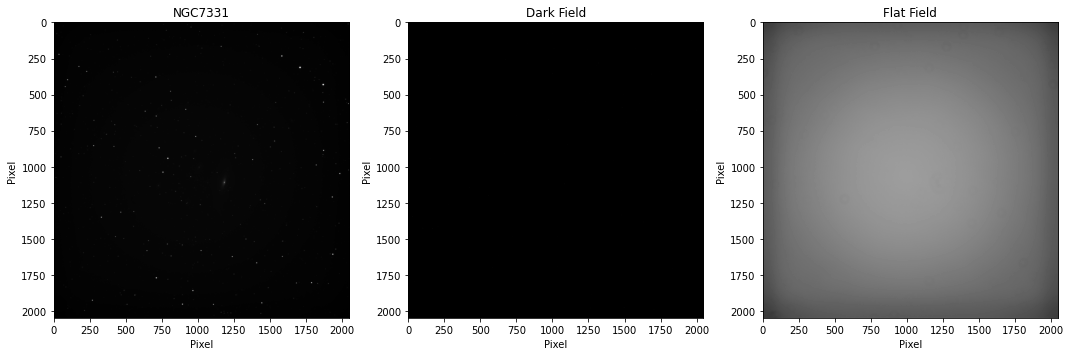

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 14))
ax[0].imshow(ngc, cmap="gray")
ax[0].set_title("NGC7331")
ax[0].set_xlabel("Pixel")
ax[0].set_ylabel("Pixel")
ax[1].imshow(dark, cmap="gray")
ax[1].set_title("Dark Field")
ax[1].set_xlabel("Pixel")
ax[1].set_ylabel("Pixel")
ax[2].imshow(flat, cmap="gray")
ax[2].set_title("Flat Field")
ax[2].set_xlabel("Pixel")
ax[2].set_ylabel("Pixel")

## Subtracting dark field and dividing flat field

Below we subtract the real image by the dark frames and then divide by the flat. 

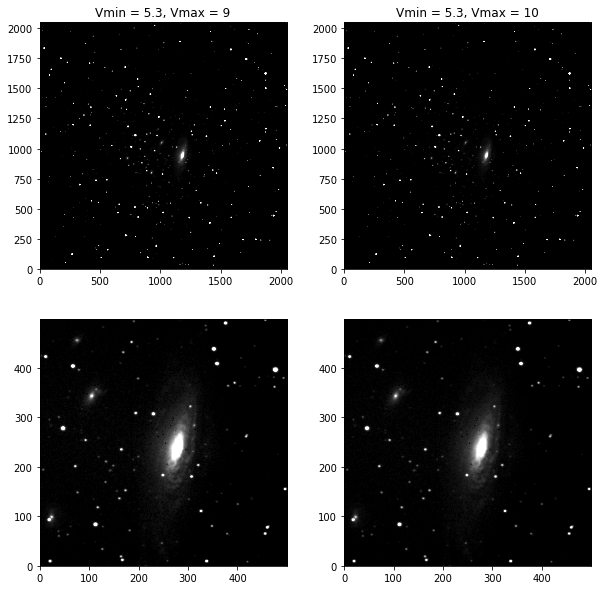

In [9]:
ngc1 = (ngc - flat) / dark
data = ngc1[::-1]
vmin, vmax = 5.3, 9
vmin1, vmax1 = 5.3, 10

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0,0].imshow(data, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
ax[0,0].invert_yaxis()
ax[0,0].set_title("Vmin = 5.3, Vmax = 9")
ax[1,0].imshow(data[700:1200, 900:1400], cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
ax[1,0].invert_yaxis()
ax[0,1].imshow(ngc1[::-1], cmap="gray", norm=LogNorm(vmin=vmin1, vmax=vmax1))
ax[0,1].invert_yaxis()
ax[0,1].set_title("Vmin = 5.3, Vmax = 10")
ax[1,1].imshow(ngc1[::-1][700:1200, 900:1400], cmap="gray", norm=LogNorm(vmin=vmin1, vmax=vmax1))
ax[1,1].invert_yaxis()

## Centroiding

In [10]:
def centroid(data):
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    cx = np.sum(x*data) / np.sum(data)
    cy = np.sum(y*data.T) / np.sum(data)
    
    return np.array([cx, cy])

In [11]:
background = np.median(data)
pixel_pos = []
box_size = 4
data_copy = data.copy()

number_of_stars = 200

for i in range(number_of_stars):
    #find brightest pixel in the image
    brightest_pixel = np.array([np.where(data_copy == np.max(data_copy))[0][0], np.where(data_copy == np.max(data_copy))[1][0]])

    #create a "box" around that pixel
    box = data_copy[brightest_pixel[0]-box_size : brightest_pixel[0]+box_size+1,
                    brightest_pixel[1]-box_size : brightest_pixel[1]+box_size+1]
    box -= background
    
    #Get the centroid of that box
    c = centroid(box)
    
    #Map the centroid of the box back onto the orginal image
    c -= np.array([box.shape[1]//2,box.shape[0]//2])
    c += brightest_pixel
    
    pixel_pos.append(c)
    
    #Remove that star from the image so it isn't the brightest pixel anymore
    box[:,:] = background

stars = np.array(pixel_pos)

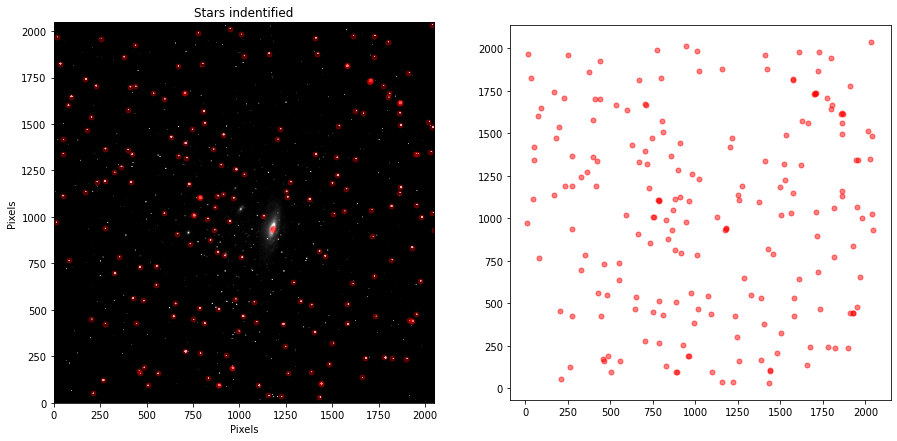

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].imshow(data, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
ax[0].plot(stars[:,1], stars[:,0], 'o', c='r', alpha=0.3, markersize=5)
ax[0].invert_yaxis()
ax[0].set_title("Stars indentified")
ax[0].set_ylabel("Pixels")
ax[0].set_xlabel("Pixels")
ax[1].plot(stars[:,1], stars[:,0], 'o', c='r', alpha=0.5, markersize=5)
ax[1].set_aspect('equal')

## USNO-B1.0 Data

In [13]:
def is_number(g):
    try:
        float(g)
        return True
    except ValueError:
        return False
#function: query Vizier USNO-B1.0 catalog
def usno(radeg,decdeg,fovam): # RA/Dec in decimal degrees/J2000.0 FOV in arc min.
    import numpy as np
    import urllib.request as url
#url format for USNO
    str1 = 'http://webviz.u-strasbg.fr/viz-bin/asu-tsv/?-source=USNO-B1'
    str2 = '&-c.ra={:4.6f}&-c.dec={:4.6f}&-c.bm={:4.7f}/{:4.7f}&-out.max=unlimited'.format(radeg,decdeg,fovam,fovam)
    #final URL: make sure it does not have any spaces or carriage returns/line feeds when copy-pasting 
    sr = str1+str2
    # Read from the webpage, storing the page's contentsin 's'. 
    f = url.urlopen(sr)
    s = f.read()
    f.close()
    #column interpretation compass
    namecol, RAcol, DECcol, rband = 0, 1, 2, 12 
    null1, null2 = ' ', ''
    #split webpage string into lines 
    sl = s.splitlines()
    sl = sl[45:-1] # get rid of header 
    name = np.array([])
    rad = np.array([]) # RA in degrees 
    ded = np.array([]) # DEC in degrees 
    rmag = np.array([]) # rmage
    #get data from each line
    for k in sl:
        kw = k.decode().split('\t')
        if kw[0] != '':
            name = np.append(name,kw[namecol])
            rad = np.append(rad,float(kw[RAcol]))
            ded = np.append(ded,float(kw[DECcol]))
            # deal with case where no mag is reported
            if is_number(kw[rband])==True:
                rmag = np.append(rmag,float(kw[rband]))
            else:
                rmag = np.append(rmag,np.nan)
                #return data
    return name,rad,ded,rmag

339.325 34.44361111111111


Text(0.5, 1.0, 'CCD Data')

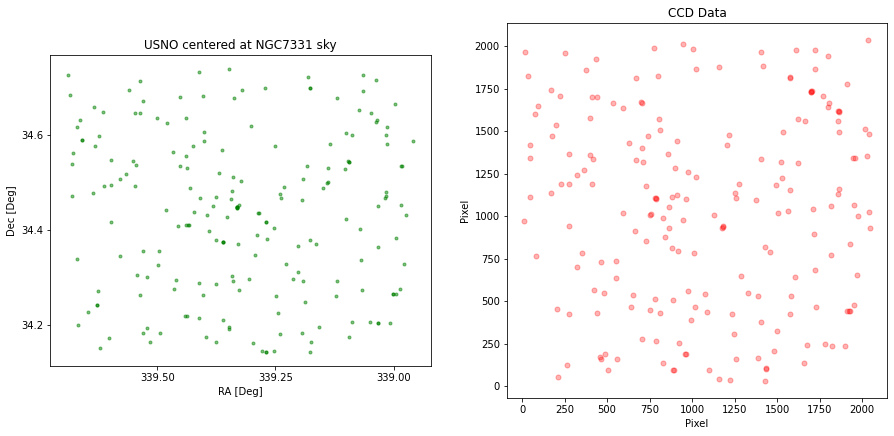

In [14]:
import astropy.io.fits as pf
import matplotlib.pyplot as plt 
import numpy as np
import urllib as url
import astropy as ap
fitsl='NGC7331-S001-R001-C001-r.fts'
sl= pf.open(fitsl)
# read position from the FITS file and convert RA/DEC to degrees 
ras = sl[0].header['ra']
des = sl[0].header['dec']
radeg = 15*(float(ras[0:2]) + float(ras[3:5])/60. + float(ras[6:])/3600.)
dsgn = np.sign(float(des[0:3]))
decdeg = float(des[0:3]) + dsgn*float(des[4:6])/60. + dsgn*float(des[7:])/3600.
print(radeg,decdeg)

fovam = 36.4 #size of square search field in arc min
name,rad,ded,rmag = usno(radeg,decdeg,fovam)
w = np.where(rmag < 14)[0] # select only bright stars r < 15 mag. 

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,8))
ax[0].plot(rad[w],ded[w],'g.',alpha=0.5)
ax[0].locator_params(axis='x',nbins=4)
ax[0].locator_params(axis='y',nbins=4) 
#ax[0].tick_params('x',pad=lO) 
ax[0].set_xlabel('RA [Deg]') 
ax[0].set_ylabel('Dec [Deg]') 
ax[0].invert_xaxis()
ax[0].set_title("USNO centered at NGC7331 sky")
ax[0].ticklabel_format(useOffset=False) 
ax[0].axis('scaled')
#ax[0].set_xlim([339.5,339.1]) #reverse the x-axis direction
ax[1].plot(stars[:,1], stars[:,0], 'o', c='r', alpha=0.3, markersize=5)
ax[1].set_aspect('equal')
ax[1].set_xlabel("Pixel")
ax[1].set_ylabel("Pixel")
ax[1].set_title("CCD Data")

## USNO Celestial Coordinates to Standard Coordinates

In [15]:
RA = radeg * np.pi/180 #rad
DEC = decdeg * np.pi/180 #rad
ra = rad[w] * np.pi/180 #rad
dec = ded[w] * np.pi/180 #rad
f = 3454 #mm
p = 0.009 * 2 #mm (x2 binning)
x0 = 1024 #shift the center back to 1024,1024
y0 = 1024
#theta = np.pi/2

X = -(np.cos(dec)*np.sin(ra-RA)) / ((np.cos(DEC)*np.cos(dec)*np.cos(ra-RA)) + (np.sin(dec)*np.sin(DEC)))
Y = -((np.sin(DEC)*np.cos(dec)*np.cos(ra-RA)) - (np.cos(DEC)*np.sin(dec))) / ((np.cos(DEC)*np.cos(dec)*np.cos(ra-RA)) + (np.sin(dec)*np.sin(DEC)))


202 202


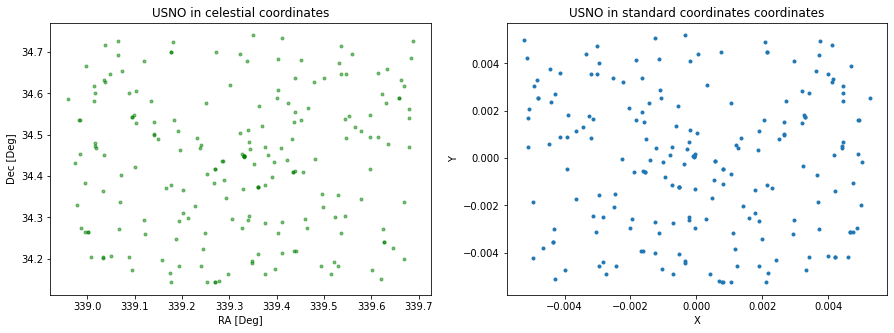

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].plot(rad[w],ded[w],'g.',alpha=0.5)
ax[0].set_xlabel('RA [Deg]') 
ax[0].set_ylabel('Dec [Deg]') 
ax[0].set_title("USNO in celestial coordinates")
ax[1].plot(X,Y, '.')
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
ax[1].set_title("USNO in standard coordinates coordinates")
print(len(rad[w]), len(ded[w]))

In [17]:
x = (f/p) * (X) + x0 
y = (f/p) * (Y) + y0

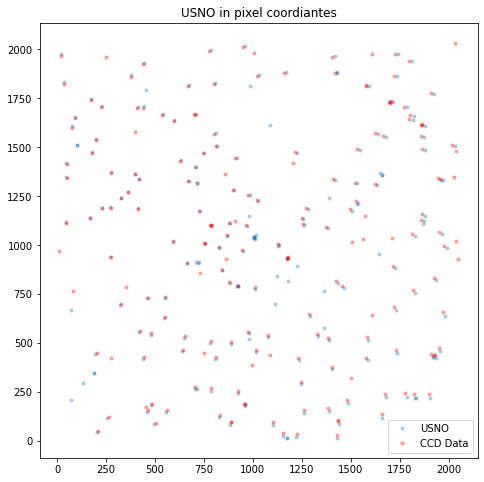

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,8))
ax.plot(x,y, '.', alpha=0.3, label="USNO") # USNO data in pixel coordinates
ax.plot(stars[:,1], stars[:,0], '.', c='r', alpha=0.3, label="CCD Data") # CCD data in pixel coordinates
ax.set_title("USNO in pixel coordiantes")
ax.set_aspect('equal')
ax.legend()

# Overlapping points

USNO: 189 189
CCD: 189 189
XY: 189 189


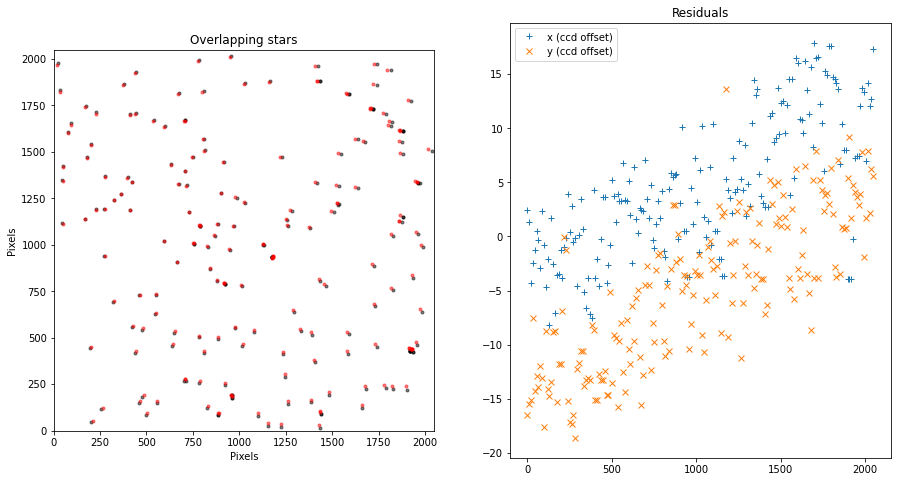

In [41]:
x_match_ccd=[]
y_match_ccd=[]
x_match_usno=[]
y_match_usno=[]
X_match = []
Y_match = []

offset=20
for i in stars[:,1]: #x,y is usno data, stars[] is ccd
    t=list(stars[:,1]).index(i) 
    for j in x:
        h=list(x).index(j)
        if i-offset<j<i+offset and stars[:,0][t]-offset<y[h]<stars[:,0][t]+offset:
                    x_match_ccd.append(i)
                    y_match_ccd.append(stars[:,0][t])
                    x_match_usno.append(j)
                    y_match_usno.append(y[h])
                    X_match.append(X[h])
                    Y_match.append(Y[h])

pixel_len = np.linspace(0, 2048, len(x_match_usno))
x_error = np.array(np.sort(x_match_usno)) - np.array(np.sort(x_match_ccd)) 
y_error = np.array(np.sort(y_match_usno)) - np.array(np.sort(y_match_ccd))  

    
print("USNO:",len(x_match_usno),len(y_match_usno))
print("CCD:", len(x_match_ccd),len(y_match_ccd))
print("XY:",len(X_match),len(Y_match))
fig, ax = plt.subplots(1,2,figsize=(15,8))
#ax.plot(x,y,'.',markersize=3,color='r')   
ax[0].plot(x_match_usno,y_match_usno,'.',color='k', alpha=0.5)                    
ax[0].plot(x_match_ccd,y_match_ccd,'.',color='r', alpha=0.5)
ax[0].set_xlim([0,2048])
ax[0].set_ylim([0,2048])
ax[0].set_aspect('equal')
ax[0].set_title("Overlapping stars")
ax[0].set_xlabel("Pixels")
ax[0].set_ylabel("Pixels")
ax[1].plot(pixel_len, np.array(x_error), '+',label="x (ccd offset)")
ax[1].plot(pixel_len, np.array(y_error), 'x',label="y (ccd offset)")
ax[1].set_title("Residuals")
ax[1].legend()

## Plate Constants

USNO data in CCD background

In [21]:
vx = np.array(x_match_ccd) # CCD data 
vy = np.array(y_match_ccd)
bx = np.array([(f/p)*np.array(X_match), (f/p)*np.array(Y_match), np.ones(len(X_match))]).T
by = np.array([(f/p)*np.array(X_match), (f/p)*np.array(Y_match), np.ones(len(Y_match))]).T

In [22]:
cx = np.matmul(np.matmul(np.linalg.inv(np.matmul(bx.T, bx)), bx.T), vx)
cy = np.matmul(np.matmul(np.linalg.inv(np.matmul(by.T, by)), by.T), vy)

print(cx) 
print(cy) 

New_x = (f/p)*cx[0]*np.array(X_match) + (f/p)*cx[1]*np.array(Y_match) + cx[2] # USNO data to pixel coordinates(CCD coordinates)
New_y = (f/p)*cy[0]*np.array(X_match) + (f/p)*cy[1]*np.array(Y_match) + cy[2] 

[ 9.91628359e-01 -6.85341538e-03  1.01997429e+03]
[6.04511178e-03 9.90647822e-01 1.02799152e+03]


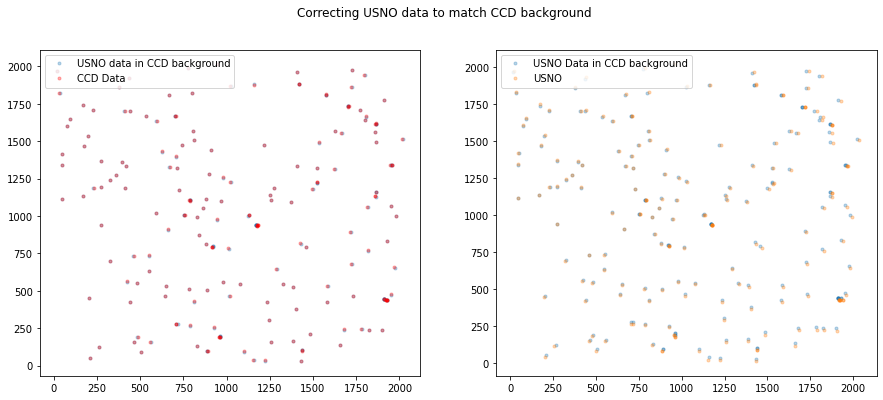

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,6))
fig.suptitle("Correcting USNO data to match CCD background")
ax[0].plot(New_x, New_y, '.', alpha=0.3, label="USNO data in CCD background")
ax[0].plot(x_match_ccd, y_match_ccd, '.', c='r', alpha=0.3, label="CCD Data")
ax[0].legend()
ax[1].plot(New_x, New_y, '.', alpha=0.3, label="USNO Data in CCD background")
ax[1].plot(x_match_usno, y_match_usno, '.', alpha=0.3, label="USNO")
ax[1].legend()

USNO standard coordinates to pixel coordinates

[ 1.00000000e+00 -5.20417043e-17  1.02400000e+03]
[-1.11022302e-16  1.00000000e+00  1.02400000e+03]


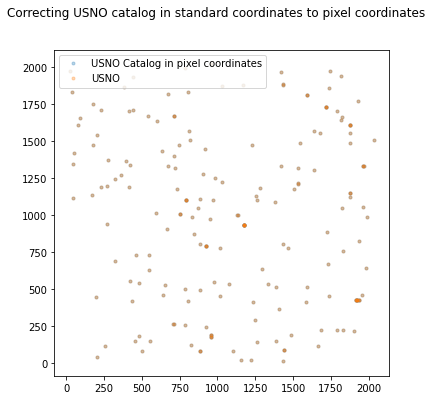

In [24]:
vx = np.array(x_match_usno)
vy = np.array(y_match_usno)
bx = np.array([(f/p)*np.array(X_match), (f/p)*np.array(Y_match), np.ones(len(X_match))]).T
by = np.array([(f/p)*np.array(X_match), (f/p)*np.array(Y_match), np.ones(len(Y_match))]).T

cx = np.matmul(np.matmul(np.linalg.inv(np.matmul(bx.T, bx)), bx.T), vx)
cy = np.matmul(np.matmul(np.linalg.inv(np.matmul(by.T, by)), by.T), vy)

print(cx) # This matrix correctly transforms from XY standard coordinates to xy pixel coordinates for the  
print(cy) # usno data as seen below 

new_x = (f/p)*cx[0]*np.array(X_match) + (f/p)*cx[1]*np.array(Y_match) + cx[2]
new_y = (f/p)*cy[0]*np.array(X_match) + (f/p)*cy[1]*np.array(Y_match) + cy[2]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6))
fig.suptitle("Correcting USNO catalog in standard coordinates to pixel coordinates")
ax.plot(new_x,new_y, '.', alpha=0.3, label="USNO Catalog in pixel coordinates")
ax.plot(x_match_usno, y_match_usno, '.', alpha=0.3, label="USNO")
ax.legend()

# Residuals

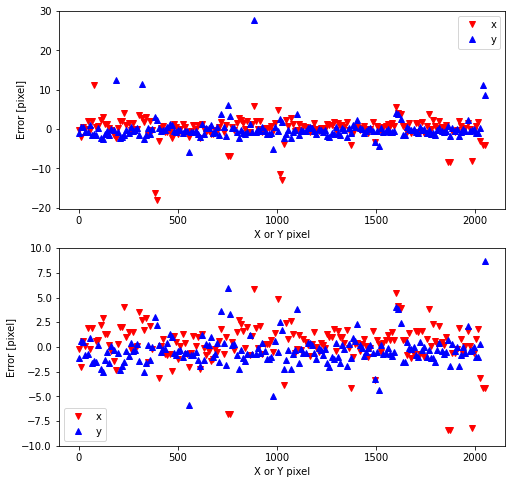

In [25]:
xerror = New_x - x_match_ccd
yerror = New_y - y_match_ccd

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
ax[0].plot(pixel_len, xerror, 'v', c='r', label='x')
ax[0].plot(pixel_len, yerror, '^', c='b', label='y')
ax[0].set_xlabel("X or Y pixel")
ax[0].set_ylabel("Error [pixel]")
ax[0].legend()
ax[1].plot(pixel_len, xerror, 'v', c='r', label='x')
ax[1].plot(pixel_len, yerror, '^', c='b', label='y')
ax[1].set_ylim(-10,10)
ax[1].set_xlabel("X or Y pixel")
ax[1].set_ylabel("Error [pixel]")
ax[1].legend()